# Hackathon:
2022 Summer
# Dataset reference
Chest X-rays: [Atelectasis/Cardiomegaly](https://www.kaggle.com/nih-chest-xrays/data) \\
Dermoscopy: [Melanoma](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main) \\
Retina Images: [Diabetic Retinopathy](https://www.kaggle.com/c/diabetic-retinopathy-detection/data) \\
Colonoscopy: [Colorectal Polyps](https://polyp.grand-challenge.org/CVCClinicDB/)


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00


## 1\. Setting up the environment

In [ ]:
!tar -zxvf Colon_Polyp.tar.gz

tar (child): Colon_Polyp.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
import os
import shutil

import gdown
import numpy as np
import pandas as pd
import torch
import torchvision
import yaml
from matplotlib import pyplot as plt
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    AddChanneld, AsChannelFirstd, Compose,
    CropForegroundd, Lambdad, LoadImaged,
    RandAffined, RandFlipd, RepeatChanneld, Resized,
    ScaleIntensityd, ScaleIntensityRanged, ToTensord,
)
from monai.utils.misc import set_determinism
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

set_determinism(42)

## 2\. Download the data and unzip it

In [ ]:
############### your code here #################
# insert group number
group_num = 5
file_name = 'Colon_Polyp.tar.gz' #changed file_name
############### your code here #################

assert group_num in range(1, 13), 'invalid group number'

file_ids = [
    '1_pFOvsNGbi8q5Qk2pt6Vp7pawqsAb_GJ', '1FUNkqg5NBe9158R4LcdzrZ5t2xRG8Rmy',
    '1871mE1E8fuUOwdnWW2nq-WGke3qHKLwM', '1BiWwiNE-hkyZpQYJN3zNT0cdeDT7WbkO',
    '1s-2vorKmg-qm7VK--jZgyZp4kWK3Vg8I', '18iY7nZrbAFo_JNd0-NDXgWDXlVG9zhDQ',
    '1FnC-KU_AbBNfoJTmByB19Ov3Ob_cX0kE', '1aGgUSvwCw1Yu2Yamwr9aeHiMqRu1B-SZ',
    '1_BlAZFAta4QVNX4NMR34-ob4BGtOAwby', '1-9i6WU_aQNXY77b8aaA9JXZsm5KjMbsn',
    '1tN7TDmhmIRRF9MuPzRwEvKIGdbGLSkX7', '1FUNkqg5NBe9158R4LcdzrZ5t2xRG8Rmy'
]

disease_list = [
    'Atelectasis', 'Cardiomegaly',
    'Melanoma', 'Diabetic Retinopathy',
    'Colon Polyp'
]

disease_name = disease_list[(group_num-1)%5]
zip_file = disease_name.replace(' ', '_') + '.tar.gz'
folder = disease_name.replace(' ', '_')

if not os.path.exists(file_name):
    id = file_ids[(group_num-1)]
    print('Unzipping...')
    cmd = f'unzip {file_name}' #changed the default file to the dataset
    os.system(cmd)
    print('done')
    gdown.download(id=id, output=zip_file)
else:
    print("Data already exist!")

Unzipping...
done


Downloading...
From: https://drive.google.com/uc?id=1s-2vorKmg-qm7VK--jZgyZp4kWK3Vg8I
To: /content/Colon_Polyp.tar.gz
100%|██████████| 19.2M/19.2M [00:00<00:00, 29.8MB/s]


In [ ]:
zip_file

'Colon_Polyp.tar.gz'

In [ ]:
# unzip the file
if not os.path.exists(folder) and os.path.exists(zip_file):
    print("Data unzipping")
    cmd = f'tar -zxf {zip_file}'
    os.system(cmd)
    print('Done')
else:
    print("Zip file doesn't exist or has been unzipped" )

Data unzipping
Done


## 3\. Load and view data


### 3-1. Checking dataset status

In [ ]:
# Set the path and load the csv
table_file = f'{folder}/{folder}.csv'
df = pd.read_csv(table_file)
print(df[:3])

               Path  Colon Polyp
0  images/100_1.tif            1
1  images/103_1.tif            1
2  images/103_2.tif            1


In [ ]:
# Check how much data we have
positive_list = list(df[df[disease_name]==1].index)
negative_list = list(df[df[disease_name]==0].index)
print(f'Number of positive cases: {len(positive_list)}')
print(f'Number of negative cases: {len(negative_list)}')
print(f'Number of total cases: {len(positive_list+negative_list)}')

Number of positive cases: 200
Number of negative cases: 200
Number of total cases: 400


### 3-2. Split data

In [ ]:
############### change here #################
# number of data for train, valid, test
data_n = [320, 40, 40]
############### change here #################

assert sum(data_n) == len(df), 'invalid split'
train_n, valid_n, test_n = data_n

# Set seed for reproducibility
seed = 42

# Separate data into training, validation, and testing set
train_list, test_list = train_test_split(
    df,
    train_size=train_n,
    test_size=valid_n+test_n,
    stratify=df[disease_name],
    random_state=seed,
    shuffle=True
)

valid_list, test_list = train_test_split(
    test_list,
    train_size=valid_n,
    test_size=test_n,
    stratify=test_list[disease_name],
    random_state=seed,
    shuffle=True
)

train_list = list(train_list.index)
valid_list = list(valid_list.index)
test_list = list(test_list.index)

train_list = [
    {
        'image': df.iloc[index]['Path'],
        'label': float(df.iloc[index][disease_name])
    }
    for index in train_list
]
valid_list = [
    {
        'image': df.iloc[index]['Path'],
        'label': float(df.iloc[index][disease_name])
    }
    for index in valid_list
]
test_list = [
    {
        'image': df.iloc[index]['Path'],
        'label': float(df.iloc[index][disease_name])
    }
    for index in test_list
]

print(f'{len(train_list)} data for training: {train_list[:2]}')
print(f'{len(valid_list)} data for validation: {valid_list[:2]}')
print(f'{len(test_list)} data for testing: {test_list[:2]}')

320 data for training: [{'image': 'images/84_1.tif', 'label': 1.0}, {'image': 'images/450_2.tif', 'label': 1.0}]
40 data for validation: [{'image': 'images/310_1.tif', 'label': 0.0}, {'image': 'images/94_3.tif', 'label': 0.0}]
40 data for testing: [{'image': 'images/353_2.tif', 'label': 1.0}, {'image': 'images/568_2.tif', 'label': 1.0}]


In [ ]:
def check_dist(data_list):
    positive = 0
    for data in data_list:
        positive += data['label']
    negative = len(data_list) - positive
    print(
        f'number of positive = {positive:.0f}, '
        f'number of negative = {negative:.0f}, '
        f'number of total data = {len(data_list)}'
    )

check_dist(train_list)
check_dist(valid_list)
check_dist(test_list)

number of positive = 160, number of negative = 160, number of total data = 320
number of positive = 20, number of negative = 20, number of total data = 40
number of positive = 20, number of negative = 20, number of total data = 40


## 3-3. Data pre-processing, data visualization





In [ ]:
############### your code here #################

preprocess = [
    Resized(keys='image', spatial_size=[224, 224])
]

augmentation = [
                RandAffined(
    keys='image',
    rotate_range=0,
    shear_range=0,
    translate_range=0,
    scale_range=2,
    prob=1,
    padding_mode='border'
)
]

cache_rate = 0

############### your code here #################

load = [
    Lambdad(keys='image', func=lambda p: f'{folder}/{p}'),
    LoadImaged(keys='image', reader='pilreader'),
    ToTensord(keys=['image', 'label'])
]

if disease_name in ['Atelectasis', 'Cardiomegaly']:
    load += [AddChanneld(keys=['image', 'label'])]
    preprocess += [RepeatChanneld(keys='image', repeats=3)]
else:
    load += [
        AsChannelFirstd(keys='image'),
        AddChanneld(keys='label')
    ]

train_transform = Compose(load+preprocess+augmentation)
valid_transform = Compose(load+preprocess)
test_transform = Compose(load+preprocess)

train_set = CacheDataset(train_list, train_transform, cache_rate=cache_rate)
valid_set = CacheDataset(valid_list, valid_transform, cache_rate=cache_rate)
test_set = CacheDataset(test_list, test_transform, cache_rate=cache_rate)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AsChannelFirstd'>: Class `AsChannelFirstd` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor da

In [ ]:
data = train_set[10]

#print(data['image'])
print(data['image'].size())
print(data['image'].max())
print(data['image'].min())

torch.Size([3, 224, 224])
metatensor(254.9853)
metatensor(21.5653)


In [ ]:
# helper function for plotting image
def plot_images(data, plot_hist=False):
    column = 2 if plot_hist else 1
    fig, axis = plt.subplots(1, column, figsize=(5*column, 4))

    title = f"Label: {data['label'].item()}"
    image = data['image']
    image = image.permute(2, 1, 0)
    if plot_hist:
        counts, bins = np.histogram(image, bins=256)
        axis[1].hist(bins[:-1], bins=256, weights=counts, log=True)
    else:
        axis = [axis]

    axis[0].imshow(image.astype(np.uint8)) #bug fixed
    axis[0].set_title(title)

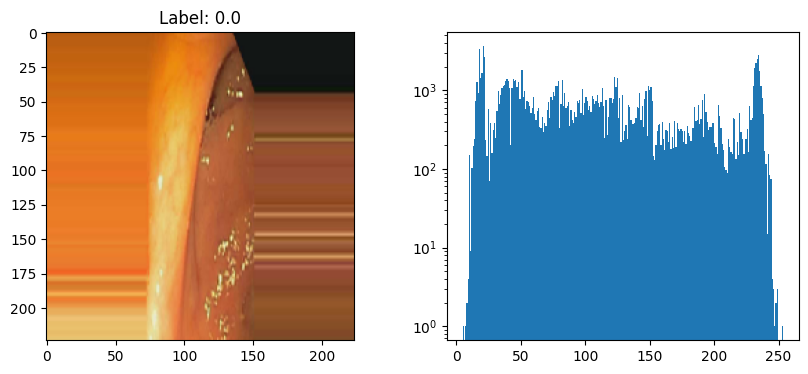

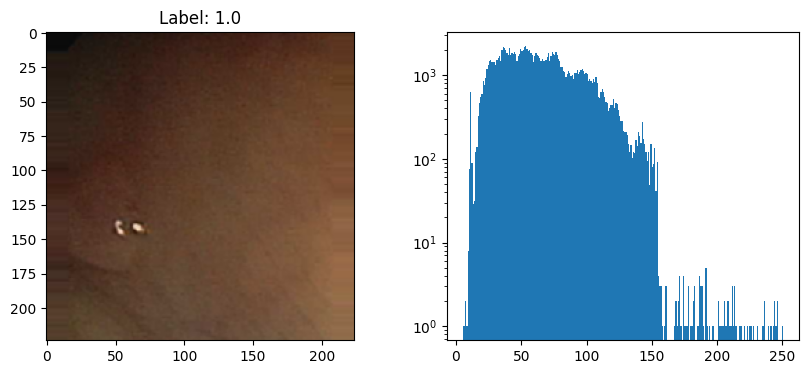

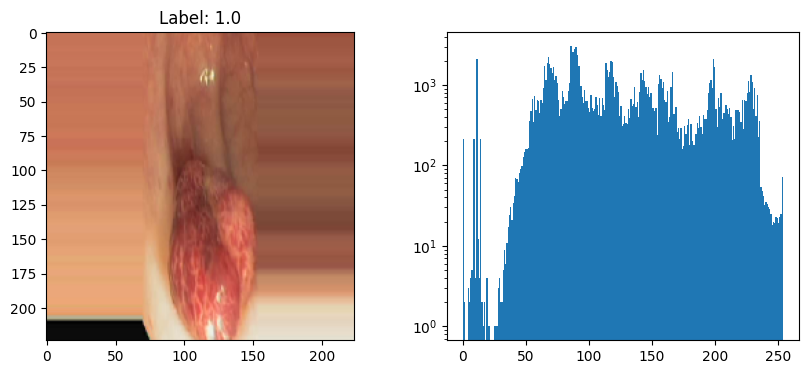

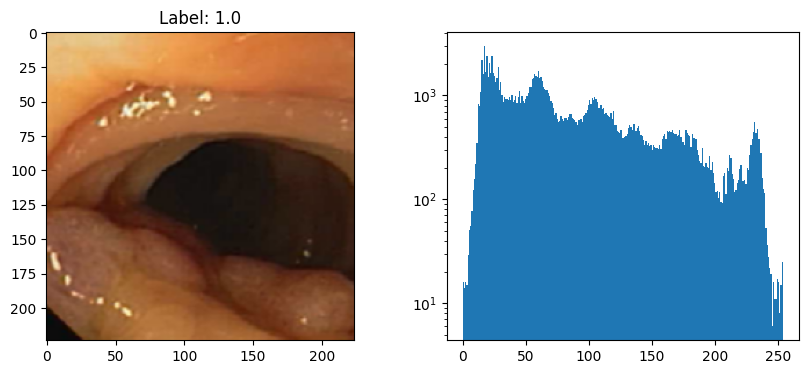

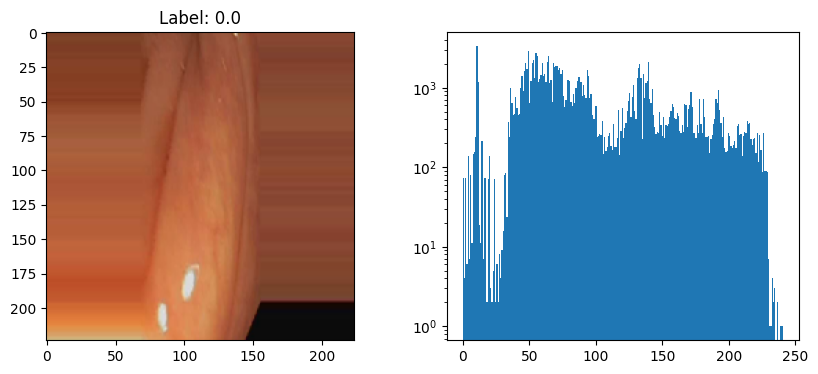

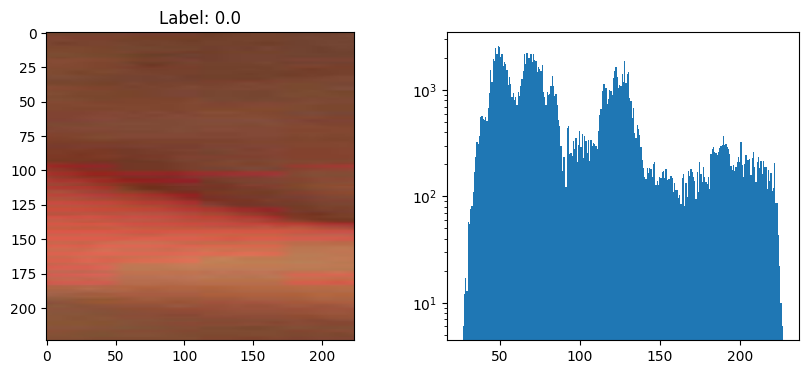

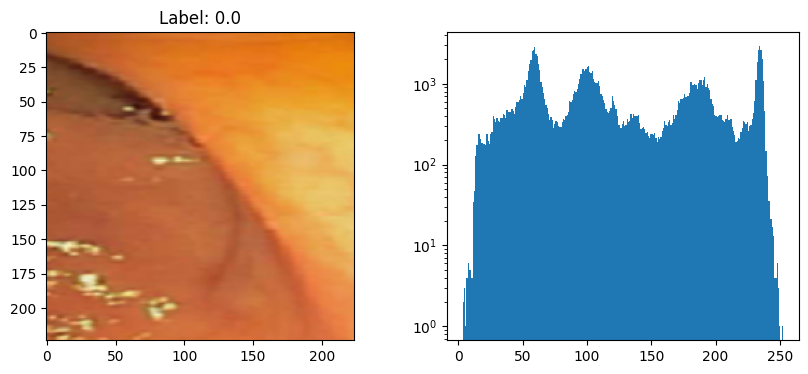

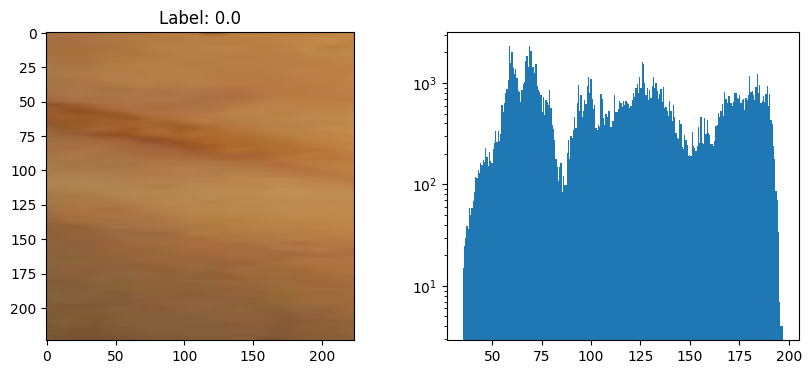

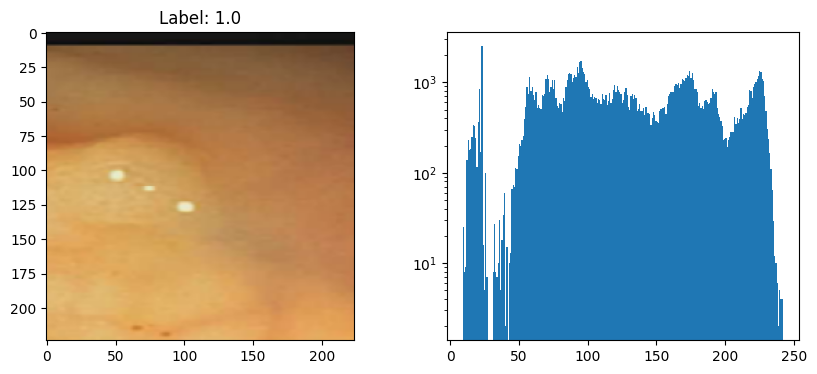

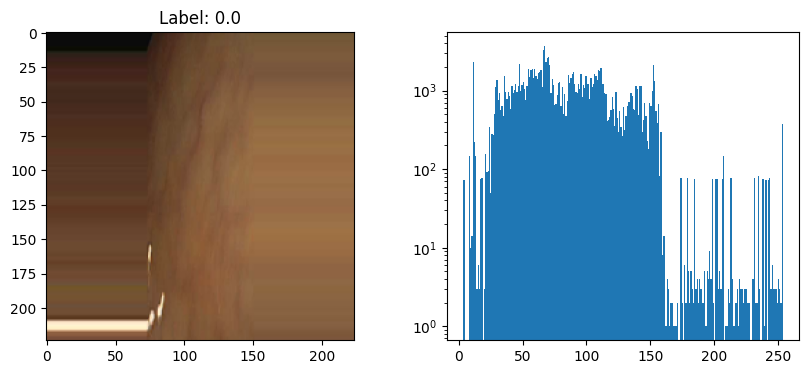

In [ ]:
random_index = np.random.randint(0, len(train_set), 10)
for index in random_index:
    #print(int(index))
    data = train_set[int(index)]
    plot_images(data, plot_hist=True)

In [ ]:
# check label distribution
def check_dist(dataset):
    positive = 0
    for data in dataset:
        positive += data['label'].item()
    negative = len(dataset) - positive
    print(
        f'number of positive = {positive:.0f}, '
        f'number of negative = {negative:.0f}, '
        f'number of total data = {len(dataset)}'
    )

check_dist(train_set)
check_dist(valid_set)
check_dist(test_set)

number of positive = 160, number of negative = 160, number of total data = 320
number of positive = 20, number of negative = 20, number of total data = 40
number of positive = 20, number of negative = 20, number of total data = 40


## 4\. Building the model


### 4-1. Download the trained model weights and set parameters

In [ ]:
############### your code here #################
# Set the model
model = torchvision.models.mobilenet_v2(
    weights='MobileNet_V2_Weights.IMAGENET1K_V2'
)
# Other models: https://pytorch.org/vision/main/models.html
# modify the last layer
model.classifier[1] = torch.nn.Linear(1280, 1)

# Set the hyperparameters
num_epoch = 30
batch_size = 25
lr = 3e-4
############### your code here #################

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
init_state = model.state_dict().copy()
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 59.3MB/s]


### 4-2. Train the model

In [ ]:
record = {'train': [], 'valid': []}
model.load_state_dict(init_state)
best_valid_loss = np.inf
for epoch in tqdm(range(num_epoch)):
    train_loss = 0.0
    valid_loss = 0.0
    # training
    model.train()
    for data in train_loader:
        images = data['image'].to(device)
        labels = data['label'].to(device)

        optimizer.zero_grad() # zero out the optimizer gradient

        preds = model(images) # model prediction
        loss = criterion(preds, labels) # calculate loss
        loss.backward() # calculate gradient of loss w.r.t. model weights
        optimizer.step() # weights update
        train_loss += loss.item()

    # validation
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images = data['image'].to(device)
            labels = data['label'].to(device)

            preds = model(images)
            loss = criterion(preds, labels)
            valid_loss += loss.item()


    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    record['train'].append(train_loss)
    record['valid'].append(valid_loss)

    # save model with lowest validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_state = model.state_dict().copy()

    print(
        f'[{epoch+1}/{num_epoch}] '
        f'Train loss: {train_loss:3.3f}, '
        f'Valid loss: {valid_loss:3.3f} '
    )


  0%|          | 0/30 [00:00<?, ?it/s]

[1/30] Train loss: 0.669, Valid loss: 0.603 
[2/30] Train loss: 0.569, Valid loss: 0.532 
[3/30] Train loss: 0.471, Valid loss: 0.413 
[4/30] Train loss: 0.406, Valid loss: 0.293 
[5/30] Train loss: 0.333, Valid loss: 0.156 
[6/30] Train loss: 0.286, Valid loss: 0.169 
[7/30] Train loss: 0.291, Valid loss: 0.279 
[8/30] Train loss: 0.269, Valid loss: 0.232 
[9/30] Train loss: 0.204, Valid loss: 0.226 
[10/30] Train loss: 0.195, Valid loss: 0.258 
[11/30] Train loss: 0.162, Valid loss: 0.175 
[12/30] Train loss: 0.159, Valid loss: 0.199 
[13/30] Train loss: 0.137, Valid loss: 0.212 
[14/30] Train loss: 0.123, Valid loss: 0.246 
[15/30] Train loss: 0.130, Valid loss: 0.380 
[16/30] Train loss: 0.156, Valid loss: 0.364 
[17/30] Train loss: 0.115, Valid loss: 0.201 
[18/30] Train loss: 0.147, Valid loss: 0.288 
[19/30] Train loss: 0.126, Valid loss: 0.270 
[20/30] Train loss: 0.108, Valid loss: 0.348 
[21/30] Train loss: 0.121, Valid loss: 0.185 
[22/30] Train loss: 0.093, Valid loss: 0.26

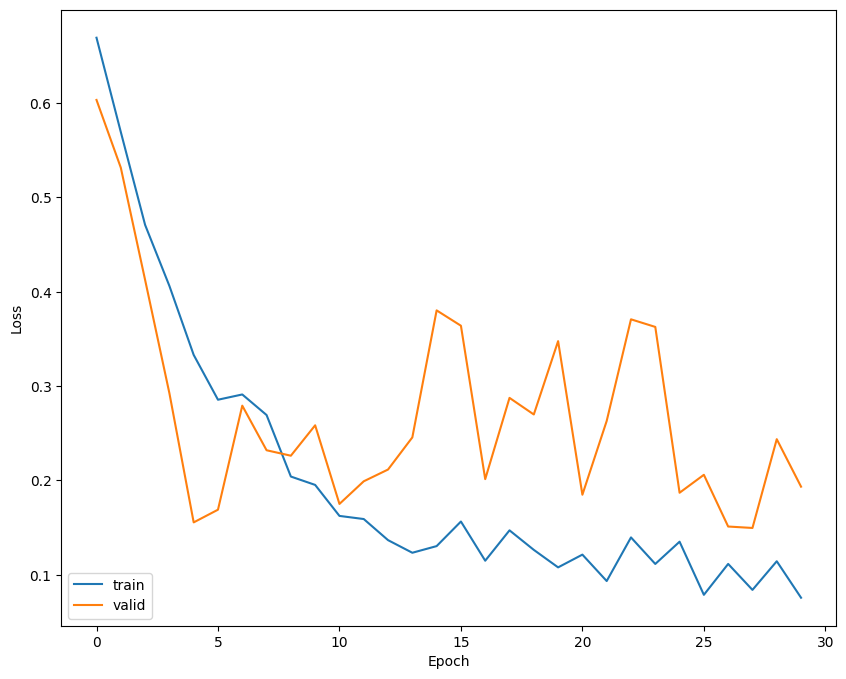

In [ ]:
# plot loss
fig, axis = plt.subplots(1, 1, figsize=(10, 8))

axis.plot(record['train'])
axis.plot(record['valid'])
axis.set_xticks(range(0, num_epoch+1, 5))
axis.set_ylabel('Loss')
axis.set_xlabel('Epoch')
axis.legend(['train', 'valid'], loc='lower left')
plt.show()

## 5\. Review results

In [ ]:
# helper function for inference and plotting
def infer(model, data_loader):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    sigmoid = torch.nn.Sigmoid()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            images = data['image'].to(device)
            labels = data['label'].to(device)

            preds = sigmoid(model(images))

            for pred, label in zip(preds, labels):
                y_pred.append(pred.item())
                y_true.append(label.item())

    return y_true, y_pred

def plot_result(y_true, y_pred, thres, title=''):
    # plot the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.show()

    # binarize the predictions
    y_pred = np.where(np.array(y_pred)>=thres, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    ############### your code here #################
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ############### your code here #################

    print(
        f'True positive: {tp}\n'
        f'False positive: {fp}\n'
        f'False negative: {fn}\n'
        f'True negative: {tn}\n'
        f'Sensitivity: {sensitivity:.4f}\n'
        f'Specificity: {specificity:.4f}'
    )

In [ ]:
# load the best weight and infer
model.load_state_dict(best_state)
train_true, train_pred = infer(model, train_loader)
valid_true, valid_pred = infer(model, valid_loader)
test_true, test_pred = infer(model, test_loader)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

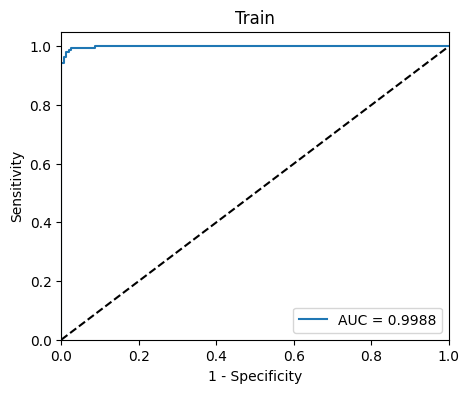

True positive: 154
False positive: 1
False negative: 6
True negative: 159
Sensitivity: 0.9625
Specificity: 0.9938




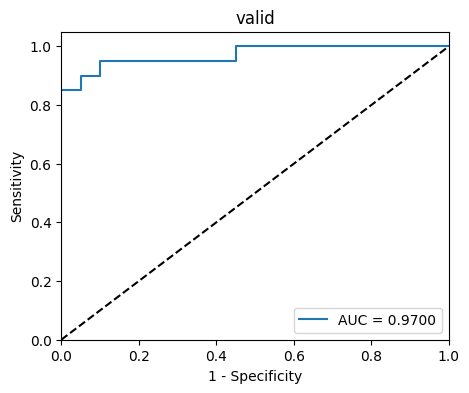

True positive: 18
False positive: 1
False negative: 2
True negative: 19
Sensitivity: 0.9000
Specificity: 0.9500




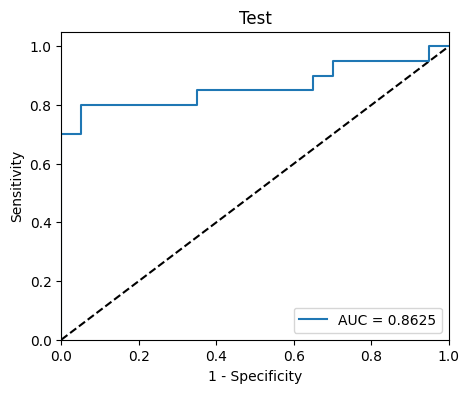

True positive: 16
False positive: 3
False negative: 4
True negative: 17
Sensitivity: 0.8000
Specificity: 0.8500


In [ ]:
############### your code here #################
thres = 0.5
############### your code here #################

plot_result(train_true, train_pred, thres=thres, title='Train')
print('\n')
plot_result(valid_true, valid_pred, thres=thres, title='valid')
print('\n')
plot_result(test_true, test_pred, thres=thres, title='Test')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')